In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<h2>Simple Encoder Decoder Network:</h2>

<h3>Designing Encoder:</h3>

In [2]:
class Encoder(tf.keras.Model):
    
    
    def __init__(self, inp_vocab_size, lstm_size, input_length):
        
        super().__init__()
        # Initializing the parameters
        self.inp_vocab_size = inp_vocab_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        
        # Initializing Embedding layer
        self.embedding = Embedding(input_dim = self.inp_vocab_size, output_dim = self.inp_vocab_size,
                                   embeddings_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 1, seed = 859),
                                   input_length = self.input_length, mask_zero = True, name = "Encoder_Embedding")
        
        #Intializing Encoder LSTM layer
        self.lstm1 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Encoder_LSTM1")
        self.lstm2 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Encoder_LSTM2")

    def call(self, input):
        
        # Unpacking the input
        input_sequence, states = input[0], input[1]
        
        # Passing input sequence to embedding layer
        input_embedded = self.embedding(input_sequence)
        
        # Passing embedidng layer output to lstm layer
        self.enc_output, self.last_hidden_state, self.last_current_state = self.lstm1(input_embedded, initial_state = states)
        self.enc_output, self.last_hidden_state, self.last_current_state = self.lstm2(self.enc_output, [self.last_hidden_state, self.last_current_state])
        
        # Returning the outputs
        return self.enc_output, self.last_hidden_state, self.last_current_state
      
    def initialize_states(self, batch_size):
      
      self.first_hidden_state, self.first_current_state = tf.zeros([batch_size, self.lstm_size]), tf.zeros([batch_size, self.lstm_size])
      # Returning the initializations
      return self.first_hidden_state, self.first_current_state

<h3>Designing Decoder:</h3>

In [3]:
class Decoder(tf.keras.Model):
    
    
    def __init__(self, out_vocab_size, lstm_size, input_length):

        super().__init__()
        # Initializing the parameters
        self.out_vocab_size = out_vocab_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        
        # Initializing Embedding layer
        self.embedding = Embedding(input_dim = self.out_vocab_size, output_dim = self.out_vocab_size, input_length = self.input_length, mask_zero = True,
                                   name = "embedding_layer_decoder")
        
        # Intializing Decoder LSTM layer
        self.lstm = LSTM(self.lstm_size, return_sequences = True, return_state = True, name = "Encoder_LSTM")

    def call(self, input):

        # Unpacking the input
        input_sequence, states = input[0], input[1]
        
        # Passing input sequence to embedding layer
        target_embedd = self.embedding(input_sequence)
        
        # Passing embedidng layer output to lstm layer
        dec_output, last_hidden_state, last_current_state = self.lstm(target_embedd, initial_state = states)
        
        # Returning the outputs
        return dec_output, last_hidden_state, last_current_state

<h3>Designing Encoder Decoder Model:</h3>

In [4]:
class Encoder_Decoder(tf.keras.Model):
    
    def __init__(self, inp_vocab_size, out_vocab_size, lstm_size, input_length, batch_size):
    
        super().__init__()
        # Initializing the parameters
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.inp_vocab_size = inp_vocab_size + 1
        self.out_vocab_size = out_vocab_size + 1
        self.batch_size = batch_size
        
        #Creating Encoder model object
        self.encoder = Encoder(inp_vocab_size = self.inp_vocab_size, lstm_size = self.lstm_size, input_length = self.input_length)
        
        #Creating Decoder model object
        self.decoder = Decoder(out_vocab_size = self.out_vocab_size, lstm_size = self.lstm_size, input_length = self.input_length)
        
        #Intializing Dense layer of length out_vocab_size with softmax activation
        self.dense   = Dense(self.out_vocab_size, activation = 'softmax')
    
    def call(self, data):
        
        # Unpacking data
        enc_inp, dec_inp = data[0], data[1]
        
        # Initializing Encoder initial states
        initial_state = self.encoder.initialize_states(self.batch_size)
        
        # Calling Encoder model object
        encoder_output, encoder_hidden, encoder_current = self.encoder([enc_inp, initial_state])
        # Calling Decoder model object
        decoder_output, decoder_hidden, decoder_current = self.decoder([dec_inp, [encoder_hidden, encoder_current]])
        # Calling output dense layer
        output = self.dense(decoder_output)
        
        # Returning outputs
        return output

<h2>Designing the Data Pipeline:</h2>

<h3>Preprocessing the Data:</h3>

In [5]:
class Dataset:
    
    def __init__(self, data, tknizer_informal, tknizer_formal, max_len):
        
        self.encoder_inps = data['encoder_inp'].values
        self.decoder_inps = data['decoder_inp'].values
        self.decoder_outs = data['decoder_out'].values
        self.tknizer_informal = tknizer_informal
        self.tknizer_formal = tknizer_formal
        self.max_len = max_len

    def __getitem__(self, i):
        
        
        # Tokenizing the sequences by passing them in lists as required by tokenizer
        self.encoder_inp_seq = self.tknizer_informal.texts_to_sequences([self.encoder_inps[i]])
        self.decoder_inp_seq = self.tknizer_formal.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_formal.texts_to_sequences([self.decoder_outs[i]])
        
        # Padding the sequences with zeros
        self.encoder_inp_seq = pad_sequences(self.encoder_inp_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        return self.encoder_inp_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        
        return len(self.encoder_inps)

<h3>Creating Dataloader:</h3>

In [6]:
class Dataloader(tf.keras.utils.Sequence):    
    
    def __init__(self, dataset, batch_size = 1):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        
        # Tracking indices of start and stop
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Creating data in tuples of form ([[encoder_inp], [decoder_inp]], decoder_out)
        batch = [np.squeeze(np.stack(samples, axis = 1), axis = 0) for samples in zip(*data)]
        
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        
        self.indexes = np.random.permutation(self.indexes)

In [7]:
# Lading pickle objects
train = joblib.load('train.pkl')
validation = joblib.load('validation.pkl')
test = joblib.load('test.pkl')

print(f"Shape of Training set: {train.shape}")
print(f"Shape of Validation set: {validation.shape}")
print(f"Shape of Test set: {test.shape}")

tknizer_informal = joblib.load('tknizer_informal.pkl')
tknizer_formal = joblib.load('tknizer_formal.pkl')

# Printing sizes of vocabularies
vocab_size_informal = len(tknizer_informal.word_index.keys())
print(f"\nVocab size of Informal text: {vocab_size_informal}")

vocab_size_formal = len(tknizer_formal.word_index.keys())
print(f"Vocab size of Formal text: {vocab_size_formal}")

Shape of Training set: (7484, 3)
Shape of Validation set: (197, 3)
Shape of Test set: (192, 3)

Vocab size of Informal text: 120
Vocab size of Formal text: 92


In [8]:
# Defining parameters
BATCH_SIZE = 64
MAX_LEN = 200

# Preprocessing data
train_dataset = Dataset(train, tknizer_informal, tknizer_formal, MAX_LEN)
validation_dataset  = Dataset(validation, tknizer_formal, tknizer_formal, MAX_LEN)

# Creating Dataloader
train_dataloader = Dataloader(train_dataset, batch_size = BATCH_SIZE)
validation_dataloader = Dataloader(validation_dataset, batch_size = BATCH_SIZE)

# Checking the dimensions 
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 200) (64, 200) (64, 200)


<h2>Training the Encoder Decoder Model:</h2>

<h3>Creating model callbacks:</h3>

In [9]:
def create_tensorboard_cb(model):
    
    import time
    root_logdir = os.path.join(os.curdir, model)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    logdir = os.path.join(root_logdir, run_id)
    return tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

<h3>Training the Encoder Decoder Model:</h3>

In [11]:
# Defining model parameters
UNITS = 256
EPOCHS = 50
TRAIN_STEPS = train.shape[0]//BATCH_SIZE
VALID_STEPS = validation.shape[0]//BATCH_SIZE
# Creating an object of Encoder_Decoder Model class 
model  = Encoder_Decoder(inp_vocab_size = vocab_size_informal, out_vocab_size = vocab_size_formal,
                         lstm_size = UNITS, input_length = MAX_LEN, batch_size = BATCH_SIZE)
# Initializing Adam Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
# Compiling the model with 'adam' optimizer and 'sparse categorical crossentropy' loss
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy')
# Creating callbacks to control model training
learning_rate_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, verbose = 1, patience = 1, min_lr = 0.0001)
tensorboard_cb = create_tensorboard_cb("Enc_Dec_logs")
stopper_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Enc_Dec",
                                                    save_best_only = True, save_weights_only = False)
# Fitting the model on training data
model.fit(train_dataloader, steps_per_epoch = TRAIN_STEPS, epochs = EPOCHS,
              callbacks = [learning_rate_cb, tensorboard_cb, stopper_cb, checkpoint_cb],
              validation_data = validation_dataloader, validation_steps = VALID_STEPS)
model.summary()

Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 2.4323INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 250s 2s/step - loss: 2.4323 - val_loss: 1.8624 - lr: 0.0100
Epoch 2/50
116/116 [==============================] - ETA: 0s - loss: 1.6558INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 263s 2s/step - loss: 1.6558 - val_loss: 1.5061 - lr: 0.0100
Epoch 3/50
116/116 [==============================] - ETA: 0s - loss: 1.4122INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 243s 2s/step - loss: 1.4122 - val_loss: 1.3680 - lr: 0.0100
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 1.2852INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 221s 2s/step - loss: 1.2852 - val_loss: 1.2940 - lr: 0.0100
Epoch 5/50
116/116 [==============================] - ETA: 0s - loss: 1.1924INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 237s 2s/step - loss: 1.1924 - val_loss: 1.2342 - lr: 0.0100
Epoch 6/50
116/116 [==============================] - ETA: 0s - loss: 1.1192INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 229s 2s/step - loss: 1.1192 - val_loss: 1.1845 - lr: 0.0100
Epoch 7/50
116/116 [==============================] - ETA: 0s - loss: 1.0553INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 225s 2s/step - loss: 1.0553 - val_loss: 1.1447 - lr: 0.0100
Epoch 8/50
116/116 [==============================] - ETA: 0s - loss: 1.0022INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 226s 2s/step - loss: 1.0022 - val_loss: 1.1057 - lr: 0.0100
Epoch 9/50
116/116 [==============================] - ETA: 0s - loss: 0.9529INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 238s 2s/step - loss: 0.9529 - val_loss: 1.0801 - lr: 0.0100
Epoch 10/50
116/116 [==============================] - ETA: 0s - loss: 0.9124INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 255s 2s/step - loss: 0.9124 - val_loss: 1.0528 - lr: 0.0100
Epoch 11/50
116/116 [==============================] - ETA: 0s - loss: 0.8843
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
116/116 [==============================] - 256s 2s/step - loss: 0.8843 - val_loss: 1.0759 - lr: 0.0100
Epoch 12/50
116/116 [==============================] - ETA: 0s - loss: 0.7748INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 295s 3s/step - loss: 0.7748 - val_loss: 0.9416 - lr: 0.0050
Epoch 13/50
116/116 [==============================] - ETA: 0s - loss: 0.7189INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 402s 3s/step - loss: 0.7189 - val_loss: 0.9105 - lr: 0.0050
Epoch 14/50
116/116 [==============================] - ETA: 0s - loss: 0.6918INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 255s 2s/step - loss: 0.6918 - val_loss: 0.8953 - lr: 0.0050
Epoch 15/50
116/116 [==============================] - ETA: 0s - loss: 0.6633INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 272s 2s/step - loss: 0.6633 - val_loss: 0.8737 - lr: 0.0050
Epoch 16/50
116/116 [==============================] - ETA: 0s - loss: 0.6408INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 251s 2s/step - loss: 0.6408 - val_loss: 0.8600 - lr: 0.0050
Epoch 17/50
116/116 [==============================] - ETA: 0s - loss: 0.6233INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 269s 2s/step - loss: 0.6233 - val_loss: 0.8541 - lr: 0.0050
Epoch 18/50
116/116 [==============================] - ETA: 0s - loss: 0.6067
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
116/116 [==============================] - 231s 2s/step - loss: 0.6067 - val_loss: 0.8653 - lr: 0.0050
Epoch 19/50
116/116 [==============================] - ETA: 0s - loss: 0.5319INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 230s 2s/step - loss: 0.5319 - val_loss: 0.7676 - lr: 0.0025
Epoch 20/50
116/116 [==============================] - ETA: 0s - loss: 0.4969INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 265s 2s/step - loss: 0.4969 - val_loss: 0.7612 - lr: 0.0025
Epoch 21/50
116/116 [==============================] - ETA: 0s - loss: 0.4792INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 282s 2s/step - loss: 0.4792 - val_loss: 0.7500 - lr: 0.0025
Epoch 22/50
116/116 [==============================] - ETA: 0s - loss: 0.4660
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
116/116 [==============================] - 232s 2s/step - loss: 0.4660 - val_loss: 0.7520 - lr: 0.0025
Epoch 23/50
116/116 [==============================] - ETA: 0s - loss: 0.4309INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 261s 2s/step - loss: 0.4309 - val_loss: 0.7103 - lr: 0.0012
Epoch 24/50
116/116 [==============================] - ETA: 0s - loss: 0.4136INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 233s 2s/step - loss: 0.4136 - val_loss: 0.7006 - lr: 0.0012
Epoch 25/50
116/116 [==============================] - ETA: 0s - loss: 0.4047INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 251s 2s/step - loss: 0.4047 - val_loss: 0.6988 - lr: 0.0012
Epoch 26/50
116/116 [==============================] - ETA: 0s - loss: 0.3968INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 232s 2s/step - loss: 0.3968 - val_loss: 0.6913 - lr: 0.0012
Epoch 27/50
116/116 [==============================] - ETA: 0s - loss: 0.3893INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 259s 2s/step - loss: 0.3893 - val_loss: 0.6867 - lr: 0.0012
Epoch 28/50
116/116 [==============================] - ETA: 0s - loss: 0.3820INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 253s 2s/step - loss: 0.3820 - val_loss: 0.6844 - lr: 0.0012
Epoch 29/50
116/116 [==============================] - ETA: 0s - loss: 0.3742INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 255s 2s/step - loss: 0.3742 - val_loss: 0.6817 - lr: 0.0012
Epoch 30/50
116/116 [==============================] - ETA: 0s - loss: 0.3686INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 271s 2s/step - loss: 0.3686 - val_loss: 0.6785 - lr: 0.0012
Epoch 31/50
116/116 [==============================] - ETA: 0s - loss: 0.3620
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
116/116 [==============================] - 246s 2s/step - loss: 0.3620 - val_loss: 0.6818 - lr: 0.0012
Epoch 32/50
116/116 [==============================] - ETA: 0s - loss: 0.3413INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 257s 2s/step - loss: 0.3413 - val_loss: 0.6584 - lr: 6.2500e-04
Epoch 33/50
116/116 [==============================] - ETA: 0s - loss: 0.3307INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 259s 2s/step - loss: 0.3307 - val_loss: 0.6548 - lr: 6.2500e-04
Epoch 34/50
116/116 [==============================] - ETA: 0s - loss: 0.3258INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 247s 2s/step - loss: 0.3258 - val_loss: 0.6501 - lr: 6.2500e-04
Epoch 35/50
116/116 [==============================] - ETA: 0s - loss: 0.3229
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
116/116 [==============================] - 234s 2s/step - loss: 0.3229 - val_loss: 0.6529 - lr: 6.2500e-04
Epoch 36/50
116/116 [==============================] - ETA: 0s - loss: 0.3141INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 261s 2s/step - loss: 0.3141 - val_loss: 0.6429 - lr: 3.1250e-04
Epoch 37/50
116/116 [==============================] - ETA: 0s - loss: 0.3096INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 265s 2s/step - loss: 0.3096 - val_loss: 0.6421 - lr: 3.1250e-04
Epoch 38/50
116/116 [==============================] - ETA: 0s - loss: 0.3068
Epoch 38: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
116/116 [==============================] - 218s 2s/step - loss: 0.3068 - val_loss: 0.6424 - lr: 3.1250e-04
Epoch 39/50
116/116 [==============================] - ETA: 0s - loss: 0.3029INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 242s 2s/step - loss: 0.3029 - val_loss: 0.6408 - lr: 1.5625e-04
Epoch 40/50
116/116 [==============================] - ETA: 0s - loss: 0.3010INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 231s 2s/step - loss: 0.3010 - val_loss: 0.6405 - lr: 1.5625e-04
Epoch 41/50
116/116 [==============================] - ETA: 0s - loss: 0.2996INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 217s 2s/step - loss: 0.2996 - val_loss: 0.6394 - lr: 1.5625e-04
Epoch 42/50
116/116 [==============================] - ETA: 0s - loss: 0.2983INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 220s 2s/step - loss: 0.2983 - val_loss: 0.6386 - lr: 1.5625e-04
Epoch 43/50
116/116 [==============================] - ETA: 0s - loss: 0.2970
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001.
INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 220s 2s/step - loss: 0.2970 - val_loss: 0.6385 - lr: 1.5625e-04
Epoch 44/50
116/116 [==============================] - ETA: 0s - loss: 0.2950INFO:tensorflow:Assets written to: Enc_Dec/assets


INFO:tensorflow:Assets written to: Enc_Dec/assets


116/116 [==============================] - 239s 2s/step - loss: 0.2950 - val_loss: 0.6384 - lr: 1.0000e-04
Epoch 45/50
116/116 [==============================] - 196s 2s/step - loss: 0.2939 - val_loss: 0.6386 - lr: 1.0000e-04
Epoch 46/50
116/116 [==============================] - 225s 2s/step - loss: 0.2931 - val_loss: 0.6384 - lr: 1.0000e-04
Epoch 47/50
116/116 [==============================] - 206s 2s/step - loss: 0.2922 - val_loss: 0.6387 - lr: 1.0000e-04
Epoch 47: early stopping
Model: "encoder__decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  927025    
                                                                 
 decoder_1 (Decoder)         multiple                  367049    
                                                                 
 dense_1 (Dense)             multiple                  23901     
                     

<h3>Creating Predict Function:</h3>

In [17]:
def predict(input_sentence, model):
    
    
    
    # Tokenizing and Padding the sentence
    inputs = [tknizer_informal.word_index.get(i, 0) for i in input_sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = MAX_LEN, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    # Initializing result string and hidden states
    result = ''
    hidden = tf.zeros([1, UNITS]), tf.zeros([1, UNITS])
    
    # Getting Encoder outputs
    enc_out, state_h, state_c = model.encoder([inputs, hidden])
    dec_hidden = [state_h, state_c]
    dec_input = tf.expand_dims([tknizer_formal.word_index['<']], 0)
    
    # Running loop until max length or the prediction is '>' token
    for t in range(MAX_LEN):
        # Getting Decoder outputs
        predictions, state_h, state_c = model.decoder([dec_input, dec_hidden])
        dec_hidden = [state_h, state_c]
        # Getting index of word with maximum probability
        predicted_id = tf.argmax(model.layers[2](predictions)[0][0]).numpy()
        # Getting output token
        if tknizer_formal.index_word.get(predicted_id, '') == '>':
            break
        else:
            result += tknizer_formal.index_word.get(predicted_id, '')
            dec_input = tf.expand_dims([predicted_id], 0)
    
    # Postprocessing the result string to remove spaces between punctuations
    return result

<h3>Calculating the BLEU Score:</h3>

In [18]:
# Removing '<' and '>' tokens and postprocessing punctuations to make plain texts
def rem(s):
    if s.startswith('<'):
        s = s[1:]
    if s.endswith('>'):
        s = s[:-1]
    return s

test['informals'] = test['encoder_inp'].apply(rem)
test['formals'] = test['decoder_inp'].apply(rem)

def predictor(s):
    # Modifing predictor using model
    result = predict(s, model)
    return result
test['predictions'] = test['informals'].apply(predictor)

# Process inputs for Bleu score
def convert_formals(s):
    return [s.split()]
def convert_predictions(s):
    return s.split()

test['formals'] = test['formals'].apply(convert_formals)
test['predictions'] = test['predictions'].apply(convert_predictions)

bleu_scores = [sentence_bleu(test['formals'].iloc[i], test['predictions'].iloc[i]) for i in range(len(test))]
print(f"Mean Bleu score of predictions: {np.mean(bleu_scores)}")

Mean Bleu score of predictions: 3.1277541302808807e-80


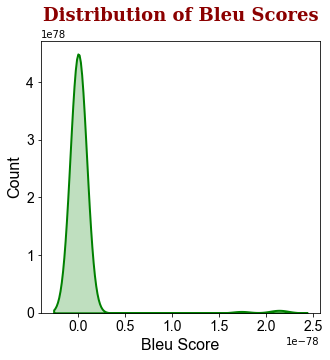

In [19]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(bleu_scores, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Bleu Scores", fontdict = title_font, pad = 20.0)
plt.xlabel("Bleu Score", fontdict = label_font)
plt.ylabel("Count", fontdict = label_font)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

In [20]:
print("Informal Sentence: wat r ya sayin")
print(f"Formal Prediction: {predict('wat r ya sayin', model)}")

Informal Sentence: wat r ya sayin
Formal Prediction: Haha. OK, I'm in exam papers?


<h2>Error Analysis:</h2>

In [21]:
# Sorting the indices by blue scores
scores = np.array(bleu_scores)
indices = np.argsort(scores)

# Getting worst score indices
worst = indices[:5]

# Getting best score indices
best = indices[-5:][::-1]

print('Best Predictions:')
print("-"*50)
for i in best:
    print(f"Informal Input : {test['informals'].iloc[i]}")
    print(f"Expected Output : {' '.join(test['formals'].iloc[i][0])}")
    print(f"Predicted Output : {' '.join(test['predictions'].iloc[i])}")
    print(f"Bleu Score of Prediction : {scores[i]}")
    print("\n")
    
print('='*100)

print('Worst Predictions:')
print("-"*50)
for i in worst:
    print(f"Informal Input : {test['informals'].iloc[i]}")
    print(f"Expected Output : {' '.join(test['formals'].iloc[i][0])}")
    print(f"Predicted Output : {' '.join(test['predictions'].iloc[i])}")
    print(f"Bleu Score of Prediction : {scores[i]}")
    print("\n")

Best Predictions:
--------------------------------------------------
Informal Input : ["Don ' t konw. I second a message to then alls, they haven ' t reply. Ibf you gointo somewhere wwith Xinyi when naver mind."]
Expected Output : Don't know. I send a message to them all, they haven't reply. If you going somewhere with Xinyi then never mind.
Predicted Output : Don't know. I don't know whether I will go to buy this bag and leave the book same circuating my hair.
Bleu Score of Prediction : 2.1732409599540408e-78


Informal Input : ["Hy. Tomorrow you want ty meet at 10am or hel after lunch tehn we dog ' to go fro the free about in ther morming?"]
Expected Output : Hey. Tomorrow you want to meet at 10am or meet after lunch then we don't go for the free about in the morning?
Predicted Output : Hey girls. So what time? I don't know whether I want to meet up today. Are you from your name or waiting more next week?
Bleu Score of Prediction : 2.097305268269639e-78


Informal Input : ["Yeal, pro